In [418]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys
sys.executable

'c:\\Users\\tutuj\\AppData\\Local\\Programs\\Python\\Python312\\python.exe'

# Utils
### - Implement

In [419]:
def get_available_actions(state, grid_reward):
    actions = []
    rows, cols = len(grid_reward), len(grid_reward[0])
    row, col = state

    if row > 0:
        actions.append(0)  # 상
    if row < rows - 1:
        actions.append(1)  # 하
    if col > 0:
        actions.append(2)  # 좌
    if col < cols - 1:
        actions.append(3)  # 우

    return actions

def get_transition(state, action, grid_reward):
    row, col = state

    if action == 0:  # 상
        next_state = (row - 1, col)
    elif action == 1:  # 하
        next_state = (row + 1, col)
    elif action == 2:  # 좌
        next_state = (row, col - 1)
    elif action == 3:  # 우
        next_state = (row, col + 1)
    else:
        raise ValueError("Invalid action")

    reward = grid_reward[next_state[0]][next_state[1]]
    return next_state, reward

# Utils
### - Given

In [420]:
def generate_grid_world(obstacles):
    grid_size = 7
    grid_reward = np.full((grid_size, grid_size), -1)

    for (x, y) in obstacles:
        grid_reward[x, y] = -100

    # Define start and end positions
    start = (0, 0)
    end = (6, 6)
    grid_reward[end[0], end[1]] = 0

    return grid_reward, start, end

def print_policy(policy):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ')
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            else:
                policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
    for row in policy_symbols:
        print(' '.join(row))

def visualize_map(data, title):
    plt.imshow(data, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Value')
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="Green")
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

def visualize_policy(policy, start, end, title, israndom):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ', dtype="U10")
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            elif (x, y) == (start[0], start[1]):
                policy_symbols[x, y] = 'S'  # Start
            else:
                if israndom:
                    policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
                else:
                    temp_policy_symbol = 0
                    actions = [int(value) for value in str(policy[x, y])]
                    for i, value in enumerate(actions):
                        if i == 0:
                            temp_policy_symbol = ACTION_SYMBOLS.get(value, ' ')
                        else:
                            temp_policy_symbol += ACTION_SYMBOLS.get(value, ' ')
                    policy_symbols[x, y] = temp_policy_symbol
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(np.arange(0, grid_size+1, 1))
    ax.set_yticks(np.arange(0, grid_size+1, 1))
    ax.set_yticklabels(np.arange(grid_size, -1, -1))
    ax.grid(True)

    for x in range(grid_size):
        for y in range(grid_size):
            if israndom:
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=20)
            else:
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=10)
            if grid[x, y] == -100:
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='black')
                ax.add_patch(rect)
            elif (x, y) == (end[0], end[1]):
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='green', alpha=0.3)
                ax.add_patch(rect)
            elif (x, y) == (start[0], start[1]):
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='blue', alpha=0.3)
                ax.add_patch(rect)

    plt.title(title)
    plt.show()

# Policy initialization
### - Implement

In [ ]:
def policy_generator(grid_reward, israndom, isall=False):
    
    rows, cols = len(grid_reward), len(grid_reward[0])
    policy = {}#np.zeros((rows, cols))
    
    for row in range(rows):
        for col in range(cols):
            actions = get_available_actions((row, col), grid_reward)#가능한 action들
            if isall:
                policy[(row, col)] = actions
            elif israndom:
                policy[(row, col)] = [np.random.choice(actions)]
            else:
                policy[(row, col)] = actions

    return policy

# Policy evaluation
### - Implement

In [422]:
def policy_evaluation(grid_reward, policy, discount_factor=0.9, theta=1e-1, israndom=True):

    rows, cols = len(grid_reward), len(grid_reward[0])
    V = np.zeros((rows, cols))

    while True:
        delta = 0
        for row in range(rows):
            for col in range(cols):
                state = (row, col)
                v = V[row, col]
                new_v = 0
                actions = policy[state]
                for action in actions:
                    next_state, reward = get_transition(state, action, grid_reward)
                    new_v += (1 / len(actions)) * (reward + discount_factor * V[next_state[0], next_state[1]])
                V[row, col] = new_v
                delta = max(delta, abs(v - new_v))
        yield V  # 각 반복마다 가치 함수 V를 반환
        if delta < theta:
            break

# Policy improvement
### - Implement

In [423]:
def policy_improvement(grid_reward, V, discount_factor=0.9):
    rows, cols = len(grid_reward), len(grid_reward[0])
    new_policy = np.zeros((rows, cols))

    for row in range(rows):
        for col in range(cols):
            state = (row, col)
            actions = get_available_actions(state, grid_reward)
            action_values = []

            for action in actions:
                next_state, reward = get_transition(state, action, grid_reward)
                action_value = reward + discount_factor * V[next_state[0], next_state[1]]
                action_values.append(action_value)

            best_action = actions[np.argmax(action_values)]
            new_policy[state] = [best_action]

    return new_policy

# Value iteration
### - Implement

In [424]:
def value_iteration(grid_reward, discount_factor=0.9, theta=1e-1):
    rows, cols = len(grid_reward), len(grid_reward[0])
    V = np.zeros((rows, cols))
    policy = policy_generator(grid_reward, israndom=True)

    while True:
        delta = 0
        for row in range(rows):
            for col in range(cols):
                state = (row, col)
                v = V[row, col]
                action_values = []

                actions = get_available_actions(state, grid_reward)
                for action in actions:
                    next_state, reward = get_transition(state, action, grid_reward)
                    action_value = reward + discount_factor * V[next_state[0], next_state[1]]
                    action_values.append(action_value)

                best_action_value = max(action_values)
                V[row, col] = best_action_value
                delta = max(delta, abs(v - best_action_value))

        if delta < theta:
            break

    for row in range(rows):
        for col in range(cols):
            state = (row, col)
            actions = get_available_actions(state, grid_reward)
            action_values = []

            for action in actions:
                next_state, reward = get_transition(state, action, grid_reward)
                action_value = reward + discount_factor * V[next_state[0], next_state[1]]
                action_values.append(action_value)

            best_action = actions[np.argmax(action_values)]
            policy[state] = [best_action]
    return V, policy

# Initialization
### -Given

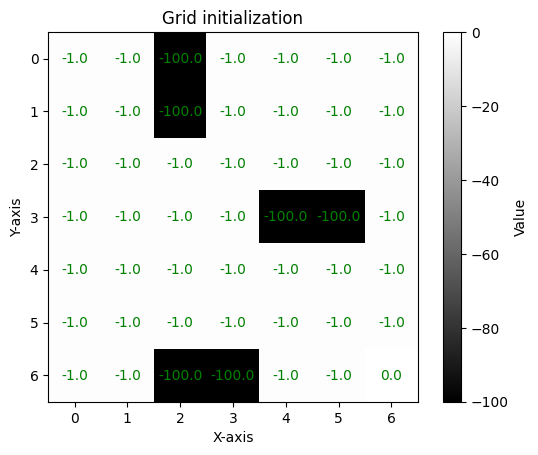

In [425]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTION_SYMBOLS = {ACTION_UP: '↑', ACTION_DOWN: '↓', ACTION_LEFT: '←', ACTION_RIGHT: '→'}

border = f"\n{'='*60}\n"
obstacles = [(0, 2), (1, 2), (3, 4), (3, 5), (6, 2), (6, 3)]
grid, start, end = generate_grid_world(obstacles)
print(border)
visualize_map(grid, "Grid initialization")
print(border)

# Show results
### - Random policy initialization
### - Given

In [426]:
# Policy initialization
random_policy = policy_generator(grid, israndom=True)
visualize_policy(random_policy, start, end, "Random Policy initialization", True)

# Policy evaluation
print(border)
idx = 0
for V_random in policy_evaluation(grid, random_policy, israndom=True):
    idx += 1
    visualize_map(V_random, f"Value Function for policy evaluation for iter: {idx}")
    print(border)

# Policy improvement
improved_policy = policy_improvement(grid, V_random)
visualize_policy(improved_policy, start, end, "Improved Policy after Policy Improvement", True)

ValueError: setting an array element with a sequence.

# Show results
### - All possible direction policy initialization
### - Given

In [ ]:
# Policy initialization
allpossibledirection_policy = policy_generator(grid, israndom=False)
visualize_policy(allpossibledirection_policy, start, end, "All possible direction Policy initialization", False)

# Policy evaluation
print(border)
idx = 0
for V_random in policy_evaluation(grid, allpossibledirection_policy, discount_factor=0.9, israndom=False):
    idx += 1
    visualize_map(V_random, f"Value Function for policy evaluation for iter: {idx}")
    print(border)

# Policy improvement
allpossibledirection_improved_policy = policy_improvement(grid, V_random)
visualize_policy(allpossibledirection_improved_policy, start, end, "Improved Policy after Policy Improvement", False)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

# Show results
### - Value iteration
### - Given

In [ ]:
V_opt, optimal_policy = value_iteration(grid)
visualize_map(V_opt, "Optimal Value Function from Value Iteration")

visualize_policy(optimal_policy, start, end, "Optimal Policy from Value Iteration", True)